In [1]:
using Distributed
Distributed.addprocs(5);

In [7]:
using Grid
using Plots
using JuMIT
gr()

Plots.GRBackend()

In [13]:
pa=J.Gallery.xfwi_problem(:pizza);

	Seismic Model:	
	> number of samples:	x	51	z	51
	> sampling intervals:	x	40.0	z	40.0
	> vp:	min	2000.0	max	2000.0
	> vp bounds:	min	1700.0	max	2300.0
	> ρ:	min	2000.0	max	2000.0
	> ρ bounds:	min	1700.0	max	2300.0
	Acquisition Geometry:	circular acquisition geometry
	> number of supersources:	5
	> sources per supersource:	min	1	max	1
	> receivers per supersource:	min	20	max	20
	> number of unique positions of:	sources	5	receivers	20
	Source Acquisition:	
	> number of supersources:	5
	> sources per supersource:	min	1	max	1
	> frequency:	min	0.3538461538461538	max	8.846153846153845	peak	2.8307692307692305
	> time:	min	0.0	max	2.8173913043478263
	> samples:	325


┌ Warning: decrease spatial sampling (4.00e+01) below 3.84e+01
└ @ JuMIT.Fdtd /math/home/pawbz/.julia/dev/JuMIT/src/Fdtd/Fdtd.jl:1005


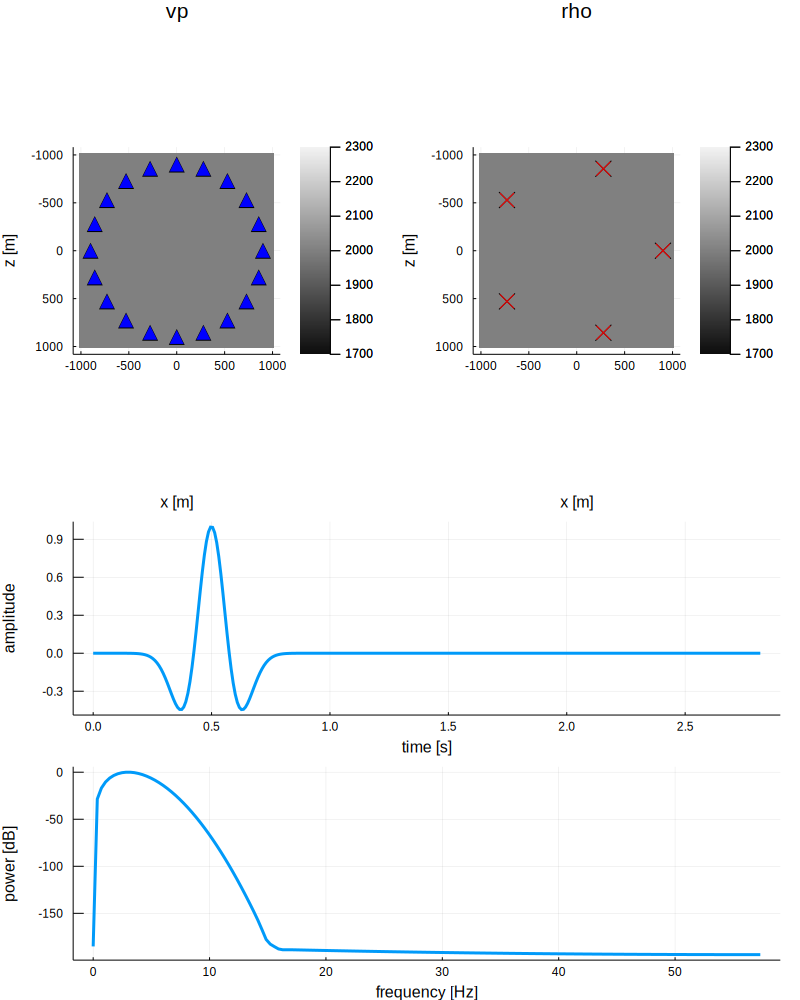

In [14]:
p1=JP.seismic(pa.modm, use_bounds=true)
JP.geom!(pa.acqgeom, markersize=7, subplot=[1,2])
p2=JP.src(pa.acqsrc, w=3)
plot(p1,p2, layout=(2,1), size=(800,1000))

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      2.26s / 100%             608KiB / 47.1%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 xfwi!          1    2.26s   100%   2.26s    286KiB  100%    286KiB
   Fadj!        1    1.52s  67.3%   1.52s   95.8KiB  33.4%  95.8KiB
   F!           1    737ms  32.6%   737ms    179KiB  62.6%   179KiB
 ──────────────────────────────────────────────────────────────────  2.495178 seconds (277.41 k allocations: 13.595 MiB)


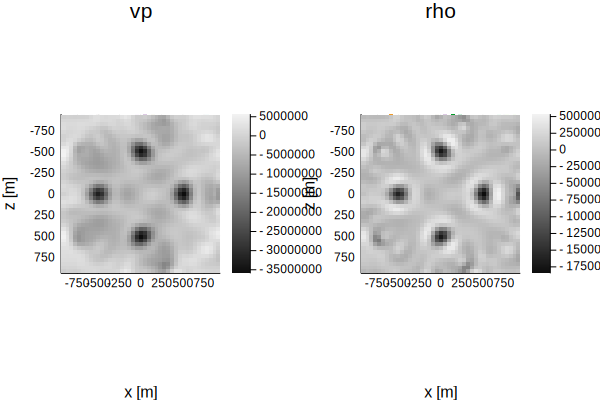

In [15]:
JF.initialize!(pa)
@time migr = JuMIT.FWI.xfwi!(pa, JuMIT.FWI.Migr())
JuMIT.Plots.seismic(migr[1])
#println(norm(migr[2]))

In [16]:
JuMIT.FWI.xfwi!(pa, JuMIT.FWI.LS(),  bounded_flag=true, solver=:ipopt,ipopt_options=[["max_iter", 30]])

updating modm and modi...


  likely near In[16]:1
  likely near In[16]:1
  likely near In[16]:1
in #xfwi! at none
┌ Warning: `Array{T}(m::Int) where T` is deprecated, use `Array{T}(undef, m)` instead.
│   caller = #xfwi!#6(::Optim.LBFGS{Nothing,LineSearches.InitialStatic{Float64},LineSearches.HagerZhang{Float64,Base.RefValue{Bool}},getfield(Optim, Symbol("##22#24"))}, ::Optim.Options{Float64,Nothing}, ::Bool, ::Symbol, ::Array{Array{Any,1},1}, ::Function, ::JuMIT.FWI.Param{JuMIT.Fdtd.Param,JuMIT.FWI.ModFdtd,JuMIT.Data.P_misfit}, ::JuMIT.FWI.LS) at TimerOutput.jl:189
└ @ JuMIT.FWI /math/home/pawbz/.julia/packages/TimerOutputs/sc5fl/src/TimerOutput.jl:189
┌ Warning: `Array{T}(m::Int) where T` is deprecated, use `Array{T}(undef, m)` instead.
│   caller = #xfwi!#6(::Optim.LBFGS{Nothing,LineSearches.InitialStatic{Float64},LineSearches.HagerZhang{Float64,Base.RefValue{Bool}},getfield(Optim, Symbol("##22#24"))}, ::Optim.Options{Float64,Nothing}, ::Bool, ::Symbol, ::Array{Array{Any,1},1}, ::Function, ::JuMIT.FWI.Param{J

> xfwi: number of inversion variables:	3362
This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     3362
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     3362
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)

-1

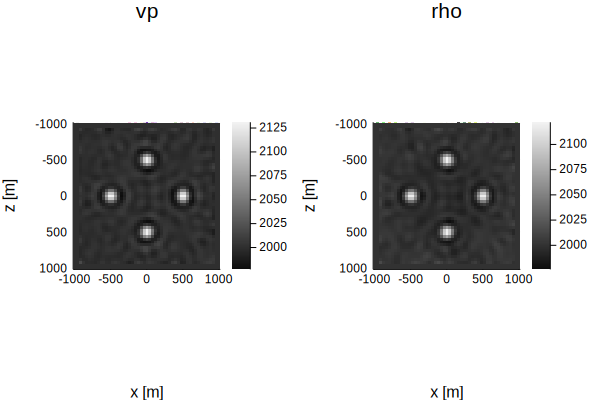

In [17]:
JP.seismic(pa.modm)